In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import sys

import rosbag
import rospy



import sensor_msgs.point_cloud2 as pc2

In [2]:
MAP_PATH = "ros_map_utils/maps/cancha.pgm"
SEM_MAP_PATH = "ros_map_utils/maps/cancha.png"

RES = 0.05
MAP_WIDTH = 0.5
MAP_HEIGHT = 0.5

Occupancy Map Size:  (2976, 2912)
Semantic Map Size:  (2976, 2912, 3)


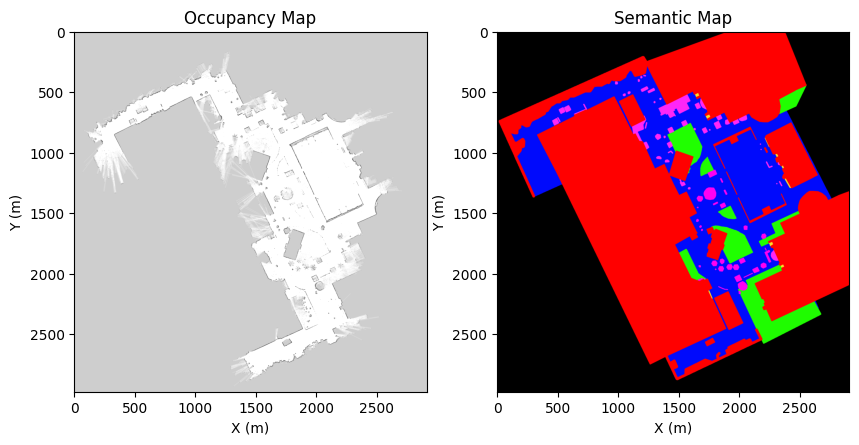

In [3]:
occ_map = cv.imread(MAP_PATH, cv.IMREAD_GRAYSCALE)
seg_map = cv.cvtColor(cv.imread(SEM_MAP_PATH), cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(occ_map, cmap='gray')
ax[0].set_title("Occupancy Map")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Y (m)")
ax[1].imshow(seg_map)
ax[1].set_title("Semantic Map")
ax[1].set_xlabel("X (m)")
ax[1].set_ylabel("Y (m)")

print("Occupancy Map Size: ", occ_map.shape)
print("Semantic Map Size: ", seg_map.shape)

In [4]:
seg_map.max()

255

True

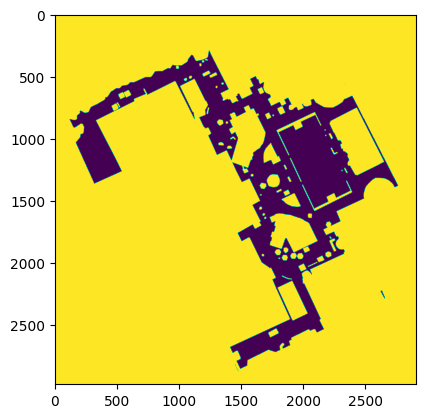

In [5]:
seg_map_gray = cv.cvtColor(seg_map, cv.COLOR_BGR2GRAY)

seg_map_gray[seg_map_gray != 81] = 1
seg_map_gray[seg_map_gray == 81] = 0

plt.imshow(seg_map_gray)

cv.imwrite("ros_map_utils/maps/canchagray.png", seg_map_gray * 255)

In [6]:
# read a rosbag file

BAG_FILE = "/home/tesistas/Desktop/GONZALO/bags/sec_b_3_2025-05-23-21-32-14.bag"

bag = rosbag.Bag(BAG_FILE, 'r')
bag.get_start_time()

odometry_xy = []
map_info = None
for topic, msg, t in bag.read_messages(topics=['/amcl_pose', "/map"]):
    # clouds.append(np.array(list(pc2.read_points(msg, field_names=("x", "y", "z"), skip_nans=True))))
    if topic == "/map":
        map_info = msg.info
        # occ_map = np.array(msg.data).reshape((msg.info.height, msg.info.width))
    else:
        odometry_xy.append([msg.pose.pose.position.x, msg.pose.pose.position.y])

bag.close()

odometry_xy = np.array(odometry_xy)
print("Odometry XY: ", odometry_xy.shape)
print("Map Info: ", map_info)

Odometry XY:  (1038, 2)
Map Info:  map_load_time: 
  secs: 1748035644
  nsecs: 969894161
resolution: 0.05000000074505806
width: 2912
height: 2976
origin: 
  position: 
    x: -57.2
    y: -90.8
    z: 0.0
  orientation: 
    x: 0.0
    y: 0.0
    z: 0.0
    w: 1.0


In [7]:
def world_to_map(x, y):
    """
    Convert world coordinates to map coordinates.
    :param x: x coordinate in world
    :param y: y coordinate in world
    :return: x, y coordinates in map
    """
    x_map = (x - map_info.origin.position.x) / map_info.resolution
    y_map = (y - map_info.origin.position.y) / map_info.resolution
    return x_map, y_map

Occupancy Map Size:  (2976, 2912)
Semantic Map Size:  (2976, 2912, 3)


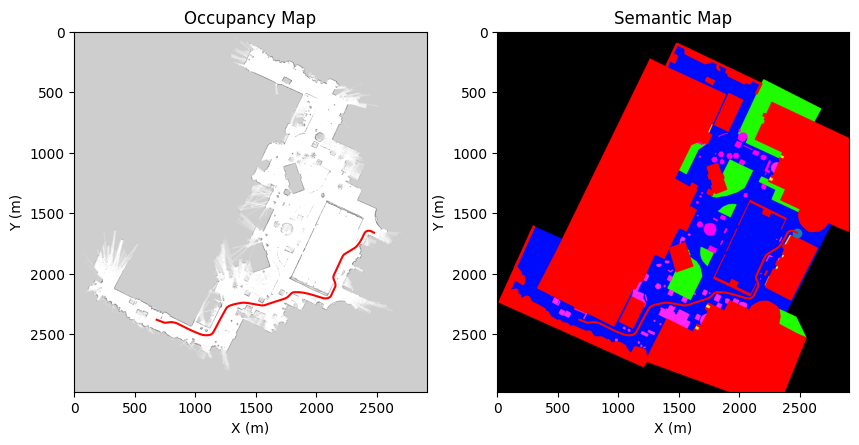

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.flipud(occ_map), cmap='gray')
ax[0].set_title("Occupancy Map")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Y (m)")
ax[1].imshow(np.flipud(seg_map))
ax[1].set_title("Semantic Map")
ax[1].set_xlabel("X (m)")
ax[1].set_ylabel("Y (m)")

xmap, ymap = world_to_map(odometry_xy[:, 0], odometry_xy[:, 1])
ax[1].plot(xmap, ymap, 'r-', label='Odometry Path')
ax[0].plot(xmap, ymap, 'r-', label='Odometry Path')

ax[1].scatter(xmap[-1], ymap[-1])

print("Occupancy Map Size: ", occ_map.shape)
print("Semantic Map Size: ", seg_map.shape)

In [9]:
def get_map_slice(map, pose, size_m=15):
    px, py = world_to_map(pose[0], pose[1])
    px, py = int(px), int(py)
    size_px2 = int(size_m / RES)

    mapc = np.flipud(map).copy()
    map_slice = mapc[py-size_px2:py+size_px2, px-size_px2:px+size_px2]
    
    origin = [px, py]

    return map_slice, origin

In [10]:
def get_path_lenght_interval(odometry_xy, start, lenght=15., N_wpts=15):
    xsq = (odometry_xy[start+1:, 0] - odometry_xy[start:-1, 0]) ** 2
    ysq = (odometry_xy[start+1:, 1] - odometry_xy[start:-1, 1]) ** 2
    distances = np.cumsum(np.sqrt(xsq + ysq), axis=0)

    stop_idx = np.where(distances >= lenght)[0][0] + start
    print(distances[stop_idx-start])
    ids = np.linspace(start, stop_idx, N_wpts, dtype=np.int64) # inlcude last point

    return odometry_xy[ids]

[-4.16730963 34.4972202 ]
[1060, 2505]
15.057938082354978


(-0.5, 599.5, 599.5, -0.5)

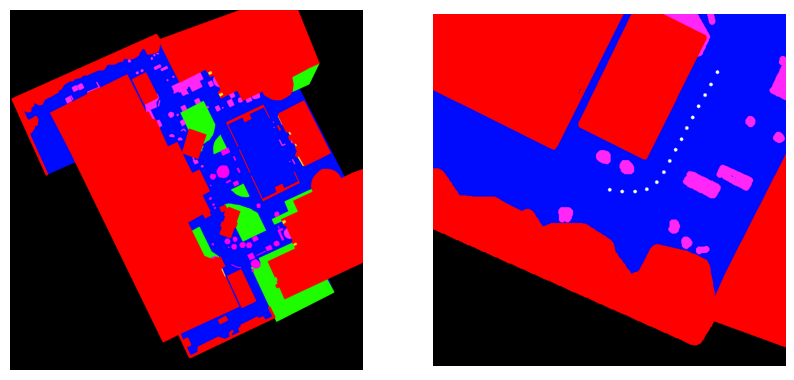

In [11]:
pt = 200

map_slice, ori = get_map_slice(occ_map, odometry_xy[pt])
map_slice_seg, _ = get_map_slice(seg_map, odometry_xy[pt])

print(odometry_xy[pt])
print(ori)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

px, py = world_to_map(odometry_xy[pt][0], odometry_xy[pt][1])

map_drawn = map_slice_seg.copy()

sampled_path = get_path_lenght_interval(odometry_xy, pt)
for (x, y) in sampled_path:
    pxi, pyi = world_to_map(x, y)
    pxi = int(pxi - ori[0] + int(15 / (RES)))
    pyi = int(pyi - ori[1] + int(15 / (RES)))

    map_drawn = cv.circle(map_drawn, (pxi, pyi), 3, (255, 255, 255), -1)


ax[0].imshow(seg_map);
ax[1].imshow(map_drawn)
ax[0].axis('off')
ax[1].axis('off')

## Data organization.

What values do we need in one sample of data?

1. Local map 
2. past 10 values of velocity
3. past 3 values of pointcloud
4. relative Goal (is it relative? nice it actually is)
5. K GT trajectories.


### 1. Local map

In [12]:
def rotate_image(image, angle, center=None):
  if center is None:
    center = tuple(np.array(image.shape[1::-1]) / 2)
  
  rot_mat = cv.getRotationMatrix2D(center, angle, 1.0)
  result = cv.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv.INTER_LINEAR)
  return result, rot_mat


def get_local_map(map, pose, size_m=15, flip=True, color=None):
    px, py = world_to_map(pose[0], pose[1])
    px, py = int(px), int(py)
    size_px2 = int(size_m / RES)

    if flip:
        mapc = np.flipud(map).copy()
    else:
        mapc = map.copy()

    mapc, R = rotate_image(mapc, pose[2] * 180 / np.pi, center=(px, py))

    map_slice = mapc[py-size_px2:py+size_px2, px-size_px2:px+size_px2]
    
    if color is not None:
        map_slice = cv.cvtColor(map_slice, cv.COLOR_BGR2GRAY)
        map_slice[map_slice != color] = 1
        map_slice[map_slice == color] = 0

    origin = [px, py]

    return map_slice, origin, R

### 2. Velocities

In [13]:
from collections import deque
import random
from cv_bridge import CvBridge

odom_topic = "/panther/odometry/filtered"
scan_topic = "/repub/ouster/points"
amcl_topic = "/amcl_pose"
img_topic  = "/repub/camera/image_raw"

N_VEL = 10  # Number of odom messages
N_LIDAR = 3  # Number of lidar messages

# Load messages from the bag
odom_msgs = []
scan_msgs = []
amcl_msgs = []
img_msgs  = []

with rosbag.Bag(BAG_FILE, 'r') as bag:
    for topic, msg, t in bag.read_messages(topics=[odom_topic, scan_topic, amcl_topic, img_topic]):
        timestamp = t.to_sec()
        if topic == odom_topic:
            odom_msgs.append((timestamp, msg))
        elif topic == scan_topic:
            scan_msgs.append((timestamp, msg))
        elif topic == amcl_topic:
            amcl_msgs.append((timestamp, msg))
        elif topic == img_topic:
            img_msgs.append((timestamp, msg))

In [14]:
# Select a random AMCL pose
amcl_msgs_lst = np.array([[msg.pose.pose.position.x, msg.pose.pose.position.y] for (t, msg) in amcl_msgs])

ind = np.random.choice(list(range(len(amcl_msgs))))
random_amcl = amcl_msgs[ind]

amcl_time, amcl_msg = random_amcl

# Helper to get last N messages before a given timestamp
def get_last_msgs(msgs, current_time, N):
    return [m for t, m in reversed(msgs) if t <= current_time][:N]

# Get previous K odom and N scan messages
odom_history = get_last_msgs(odom_msgs, amcl_time, N_VEL)
scan_history = get_last_msgs(scan_msgs, amcl_time, N_LIDAR)
img_history  = get_last_msgs(img_msgs, amcl_time, 1)

In [15]:
def world_to_local(points_world, robot_pose):
    """
    Convert world-frame points to robot-centric local frame.

    :param points_world: Nx2 array of (x, y) points in meters
    :param robot_pose: tuple (x_r, y_r, theta_r)
    :return: Nx2 array of transformed points in local frame
    """
    x_r, y_r, theta_r = robot_pose

    # Translate points so robot is at the origin
    translated = points_world - np.array([x_r, y_r])

    # Rotation matrix to align robot's heading with +Y
    c, s = np.cos(-theta_r), np.sin(-theta_r)
    R = np.array([[c, -s],
                  [s,  c]])

    local_points = translated @ R.T
    return local_points

Local Map Origin:  [1884, 2155]
Rotation Matrix:
  [[-1.38714910e-01  9.90332355e-01  1.11726659e+01]
 [-9.90332355e-01 -1.38714910e-01  4.31971679e+03]]
15.098280566264025


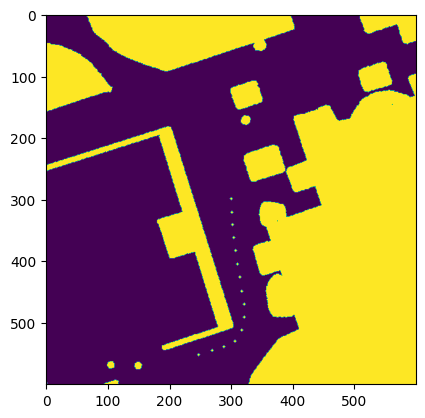

In [16]:
from tf.transformations import euler_from_quaternion
bridg = CvBridge()
img = bridg.imgmsg_to_cv2(img_history[0])


q = amcl_msg.pose.pose.orientation
_, _, yaw = euler_from_quaternion([q.x, q.y, q.z, q.w])

pose = [amcl_msg.pose.pose.position.x, amcl_msg.pose.pose.position.y, yaw + np.pi / 2]  # Convert to radians and adjust orientation

local_map, ori, R = get_local_map(seg_map, pose, color=81)

print("Local Map Origin: ", ori)
print("Rotation Matrix:\n ", R)


sampled_path = get_path_lenght_interval(amcl_msgs_lst, ind)
local_path = world_to_local(sampled_path, pose)

a = local_map.copy()
for (x, y) in local_path:
    pxi = int(x / RES + int(15 / RES))
    pyi = int(y / RES + int(15 / RES))
    a = cv.circle(a, (pxi, pyi), 2, (1), -1)

plt.imshow(img)
plt.imshow(np.flipud(a))

### 3. Lidar

/tmp/ipykernel_1610943/4281374069.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter3D(pcl[:, 0], pcl[:, 1], pcl[:, 2], cmap='Greens')


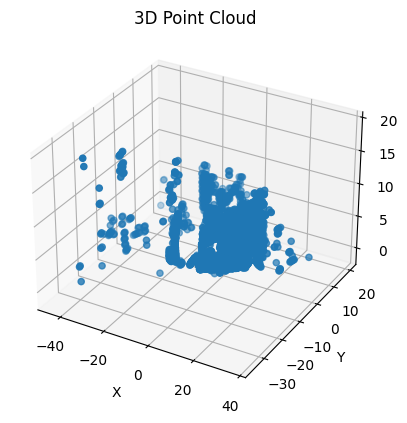

In [17]:
# done above i think
pcl = np.array(list(pc2.read_points(scan_history[0], field_names=("x", "y", "z", "intensity"), skip_nans=True)))

# 3d plot of the point cloud
ax = plt.figure().add_subplot(projection='3d')
ax.scatter3D(pcl[:, 0], pcl[:, 1], pcl[:, 2], cmap='Greens')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Point Cloud')
plt.show()

### 4. Goal

### 5. GT trajectories

dict_keys(['pose', 'vel', 'imu', 'time', 'camera', 'lidar', 'scan', 'lidar_array', 'local_map', 'path', 'all_paths'])
(15, 2)
15.409072203437452


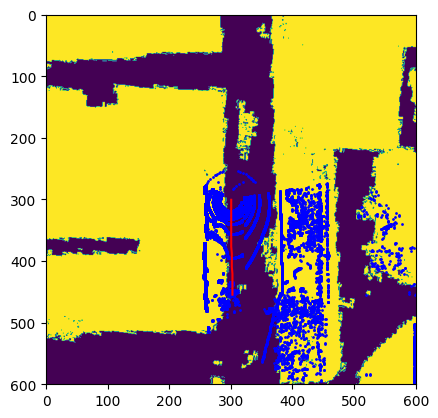

In [18]:
import pickle
with open('/home/tesistas/Desktop/GONZALO/gnd_dataset/local_map_files_120/paths/1008_0.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())

plt.imshow(data['camera'][0])
plt.imshow(data['local_map'])
plt.plot(data['path'][:, 1]/0.1+300, data['path'][:, 0]/0.1+300, 'r-')


print(data['all_paths'][0].shape)

plt.scatter(data['lidar'][0][:, 1]/0.1+300, data['lidar'][0][:, 0]/0.1+300, s=1, c='b', label='Scan Points')
plt.ylim(600, 0)
plt.xlim(0, 600)

leng = 0
for i in range(len(data['path']) - 1):
    leng += np.linalg.norm(data['path'][i] - data['path'][i + 1])
print(leng)

In [19]:
def rotate_pointcloud(pcl, theta_rad):
    # Rotation matrix around Z
    R = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad), 0],
        [np.sin(theta_rad),  np.cos(theta_rad), 0],
        [0,                  0,                 1]
    ])
    return pcl @ R.T  # Rotate each point

[[0. 0. 0.]]
(20801, 3)
[44.459099057590485, -18.050137707317106, 0.5057565428032458]


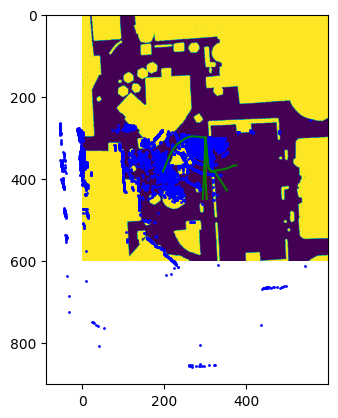

In [142]:
import pickle
with open('/home/tesistas/Desktop/GONZALO/gnd_dataset/local_map_files_120/paths/2000_0.pkl', 'rb') as f:
    data = pickle.load(f)

print(data['scan'])

# plt.imshow(data['camera'][0])
plt.imshow(data['local_map'])
plt.plot(data['path'][:, 1]/0.1+300, data['path'][:, 0]/0.1+300, 'r-')

print(data['lidar'][0].shape)
pcl = data['lidar'][0]

mask = (pcl[:, 2] < 2) & (pcl[:, 2] > 0.18) & (np.linalg.norm(pcl, axis=1) < 30)
# pcl = pcl[mask]

for path in data['all_paths']:
    # path = world_to_local(path, data['pose'])
    plt.plot(path[:, 1]/0.1+300, path[:, 0]/0.1+300, 'g-')

plt.scatter(pcl[:, 1]/0.1+300, pcl[:, 0]/0.1+300, s=1, c='b', label='Scan Points')
# plt.ylim(600, 0)
# plt.xlim(0, 600)

leng = 0
for i in range(len(data['path']) - 1):
    leng += np.linalg.norm(data['path'][i] - data['path'][i + 1])
print(data['pose'])

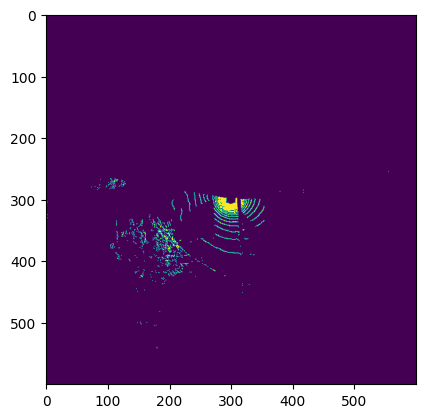

In [143]:
local_map = data['local_map']

mask1 = (pcl[:, 2] < 1.5) #& (pcl[:, 2] > 0.18) & (np.linalg.norm(pcl, axis=1) < 30)

pcl_img = np.clip(pcl / 0.1 + 300, 0, 600).astype(np.int64)
pcl_x = pcl_img[:, 1]
pcl_y = pcl_img[:, 0]

mask = (pcl_x >= 0) & (pcl_x < 600) & \
       (pcl_y >= 0) & (pcl_y < 600)

pcl_y = pcl_y[mask]
pcl_x = pcl_x[mask]

im = np.zeros((600, 600), dtype=np.uint8)

im[pcl_y, pcl_x] = 255 * (local_map[pcl_y, pcl_x])
im[pcl_y, pcl_x] = 127 * (1 - local_map[pcl_y, pcl_x])

colors = data['local_map'][pcl_y, pcl_x]
plt.imshow(im)
# plt.imshow(data['local_map'], alpha=0.1)

# categories = ['A', 'B', 'C']
# colors = {'A': 'red', 'B': 'green', 'C': 'blue'}
# for category in categories:
    # plt.scatter(x[mask], y[mask], c=colors[category], label=category)
# plt.legend()

In [156]:
import numpy as np
import open3d as o3d
from PIL import Image

def create_multi_class_bev(pcl, semantic_map, resolution=0.1, output_size=(600, 600)):
    """
    Create BEV image with multiple semantic classes and export colored PCD
    
    Args:
        pcl: Point cloud (N,3) [x,y,z]
        semantic_map: 2D numpy array with class indices (0=background, 1=class1, ...)
        resolution: meters per pixel
        output_size: (width, height) of output image
    
    Returns:
        bev_image: RGB BEV image (H,W,3)
        colored_pcl: Point cloud with class colors (N,6) [x,y,z,r,g,b]
    """
    # Define color palette (extend as needed)
    class_colors = {
        0: [0, 255, 0],       # Background (black)
        1: [255, 0, 0],     # Class 1 (red)
        2: [0, 255, 0],     # Class 2 (green)
        3: [0, 0, 255],     # Class 3 (blue)
        # Add more classes as needed
    }
    
    # Convert point cloud to pixel coordinates
    bev_width, bev_height = output_size
    pcl_img = np.clip(pcl / resolution + np.array([bev_width/2, bev_height/2, 0]), 0, max(bev_width, bev_height)-1).astype(np.int64)
    pcl_x = pcl_img[:, 1]  # BEV image x-coordinate (matrix column)
    pcl_y = pcl_img[:, 0]  # BEV image y-coordinate (matrix row)
    
    # Filter points within image bounds
    mask = (pcl_x >= 0) & (pcl_x < bev_width) & \
           (pcl_y >= 0) & (pcl_y < bev_height)
    pcl_x = pcl_x[mask]
    pcl_y = pcl_y[mask]
    filtered_pcl = pcl[mask]
    
    # Create colored BEV image
    bev_image = np.zeros((bev_height, bev_width, 3), dtype=np.uint8)
    
    # Get class indices for each point
    point_classes = semantic_map[pcl_y, pcl_x]
    
    # Color each point according to its class
    conditions = [True, filtered_pcl[:, 2] < 0.0]

    for cond, (class_idx, color) in zip(conditions, class_colors.items()):
        print(cond)
        class_mask = (point_classes == class_idx) & cond
        bev_image[pcl_y[class_mask], pcl_x[class_mask]] = color
    
    # Create colored point cloud for PCD export
    colored_pcl = np.zeros((filtered_pcl.shape[0], 6))  # x,y,z,r,g,b
    colored_pcl[:, :3] = filtered_pcl
    for cond, (class_idx, color) in zip(conditions, class_colors.items()):
        class_mask = (point_classes == class_idx) & cond
        colored_pcl[class_mask, 3:] = color
    
    return bev_image, colored_pcl


def save_colored_pcd(pcl_with_colors, filename):
    """
    Save colored point cloud to PCD file
    
    Args:
        pcl_with_colors: (N,6) array [x,y,z,r,g,b]
        filename: Output PCD filename
    """
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pcl_with_colors[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(pcl_with_colors[:, 3:] / 255.0)
    o3d.io.write_point_cloud(filename, pcd)

True
[False False False ...  True  True  True]


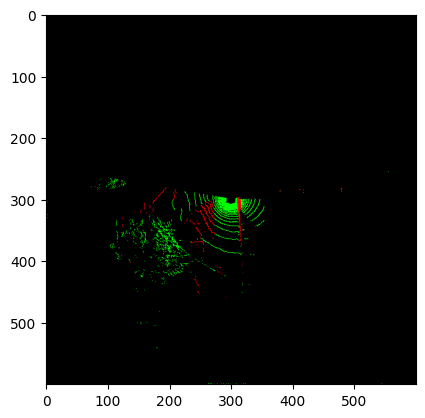

In [157]:
pcl = data['lidar'][0]  # Random point cloud
semantic_map = data['local_map']  # Random classes 0-3

# Generate BEV and colored point cloud
bev_image, colored_pcl = create_multi_class_bev(
    pcl, 
    semantic_map,
    resolution=0.1,
    output_size=(600, 600)
)

# Save results
# Image.fromarray(bev_image).save("multi_class_bev.png")
save_colored_pcd(colored_pcl, "colored_cloud.pcd")

plt.imshow(bev_image)

### que es lo que falta realmente:

1. generar todos los pkl sin gt (para todos los cosos). kinda done.
2. generar todos los gt a partir de los pkl
3. mergear los datos. Nuevo modo de la funcion original para esto.
4. sfijarse bien en los x, y
5 entrenar mierda.


In [ ]:
import pickle

file_path = '/home/tesistas/Desktop/GONZALO/gnd_dataset/local_map_files_120/data.pkl'
with open(file_path, 'rb') as f:
        data = pickle.load(f)

print(data)

{'root': ('/home/jing/Documents/gn/database/datasets/local_map_files_120/paths', '/home/jing/Documents/gn/database/datasets/local_map_files_120/planning'), 'ids': [('0_0.pkl', '0.png'), ('0_1.pkl', '0.png'), ('1_0.pkl', '1.png'), ('1_1.pkl', '1.png'), ('2_0.pkl', '2.png'), ('2_1.pkl', '2.png'), ('3_0.pkl', '3.png'), ('3_1.pkl', '3.png'), ('4_0.pkl', '4.png'), ('4_1.pkl', '4.png'), ('4_2.pkl', '4.png'), ('5_0.pkl', '5.png'), ('5_1.pkl', '5.png'), ('5_2.pkl', '5.png'), ('5_3.pkl', '5.png'), ('6_0.pkl', '6.png'), ('6_1.pkl', '6.png'), ('6_2.pkl', '6.png'), ('6_3.pkl', '6.png'), ('7_0.pkl', '7.png'), ('7_1.pkl', '7.png'), ('7_2.pkl', '7.png'), ('8_0.pkl', '8.png'), ('8_1.pkl', '8.png'), ('8_2.pkl', '8.png'), ('8_3.pkl', '8.png'), ('9_0.pkl', '9.png'), ('9_1.pkl', '9.png'), ('9_2.pkl', '9.png'), ('9_3.pkl', '9.png'), ('9_4.pkl', '9.png'), ('9_5.pkl', '9.png'), ('10_0.pkl', '10.png'), ('10_1.pkl', '10.png'), ('10_2.pkl', '10.png'), ('10_3.pkl', '10.png'), ('10_4.pkl', '10.png'), ('11_0.pkl',